# libs

In [1]:
from src.utils import load_data
from src.cross_validation_CB import CrossValidCatBoost

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import shap

import catboost as cb

import warnings
warnings.filterwarnings('ignore')

# loading data

In [2]:
%%time
train = load_data('../data/competition/train.csv')
test = load_data('../data/competition/test.csv')

profiles = load_data('../data/competition/client_profile.csv')
# bki = load_data('../data/competition/bki.csv')

(110093, 3)
(165141, 2)
(250000, 24)
Wall time: 890 ms


# preprocess

In [3]:
class Preprocess:
    
    def __init__(self, df, cat_features=None):
        self.df = df.copy()
        self.cat_features = cat_features
        
    def merge_profile(self, df):
        return df.merge(profiles, on='application_number', how='left')
    
    def fix_data(self, df):
        df['days_on_last_job'] = df['days_on_last_job'].replace(365243, np.nan)
        return df
    
    def recat_to_freq(self, df):
        
        train_test = pd.concat([
            self.merge_profile(train.copy()),
            self.merge_profile(test.copy())
        ])

        for col in self.cat_features:
            
            train_test[col] = train_test[col].fillna('None')
            df[col] = df[col].fillna('None')
            
            vc = train_test[col].value_counts().sort_values(ascending=False)

            df[col] = df[col].map({key: i for i, key in enumerate(vc.keys())})

        return df
    
    def generate_features(self, df):
        
        bki_flags = [flag for flag in df.columns if 'amt_req_credit_bureau' in flag]
        df['bki_requests_count'] = df[bki_flags].sum(axis=1)
        df['bki_kurtosis'] = df[bki_flags].kurtosis(axis=1)
        
        df['external_scoring_prod'] = df['external_scoring_rating_1'] * df['external_scoring_rating_2'] * df['external_scoring_rating_3']
        
        for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
            feature_name = f'external_scoring_rating_{function_name}'
            df[feature_name] = eval(f'np.{function_name}')(
                df[['external_scoring_rating_1', 'external_scoring_rating_2', 'external_scoring_rating_3']], axis=1
            )
            
        df['credit_to_annuity'] = df['amount_credit'] / df['amount_annuity']
        
        return df
    
    def drop_geatures(self, df):
        
        df = df.drop(['application_number'], axis=1)
        
        return df
        
    def pipline(self):
        df = self.merge_profile(self.df)
        df = self.fix_data(df)
        df = self.generate_features(df)
        df = self.recat_to_freq(df)
        df = self.drop_geatures(df)
        
        return df

In [4]:
%%time
cat_features = ['name_contract_type', 'gender', 'education_level', 'family_status']

trainPrep = Preprocess(train, cat_features=cat_features).pipline()
trainPrep[:2]

Wall time: 1.59 s


,target,name_contract_type,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,...,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,external_scoring_prod,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,credit_to_annuity
0,0,0,1,1.0,157500.0,855000.0,25128.0,0,0,0.019101,...,2.0,3.0,1.428571,0.324353,0.645914,0.71657,0.687756,0.700784,0.000917,34.025788
1,1,0,2,NaN,NaN,NaN,NaN,2,1,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# learning model

0:	learn: 0.6744620	test: 0.6652416	best: 0.6652416 (0)	total: 46.8ms	remaining: 1m 33s
200:	learn: 0.7407409	test: 0.7231331	best: 0.7231800 (193)	total: 9.28s	remaining: 1m 23s
400:	learn: 0.7545351	test: 0.7267914	best: 0.7268582 (389)	total: 18.5s	remaining: 1m 13s
600:	learn: 0.7656588	test: 0.7268605	best: 0.7272906 (442)	total: 28.1s	remaining: 1m 5s
bestTest = 0.7272905707
bestIteration = 442
Shrink model to first 443 iterations.
0:	learn: 0.6722048	test: 0.6698135	best: 0.6698135 (0)	total: 46.8ms	remaining: 1m 33s
200:	learn: 0.7414152	test: 0.7185282	best: 0.7187974 (193)	total: 9.43s	remaining: 1m 24s
400:	learn: 0.7548948	test: 0.7217782	best: 0.7217782 (400)	total: 19s	remaining: 1m 15s
600:	learn: 0.7667418	test: 0.7220558	best: 0.7225161 (511)	total: 28.9s	remaining: 1m 7s
800:	learn: 0.7765993	test: 0.7228810	best: 0.7228980 (799)	total: 38.5s	remaining: 57.7s
bestTest = 0.7228980362
bestIteration = 799
Shrink model to first 800 iterations.
0:	learn: 0.6717460	test: 0.

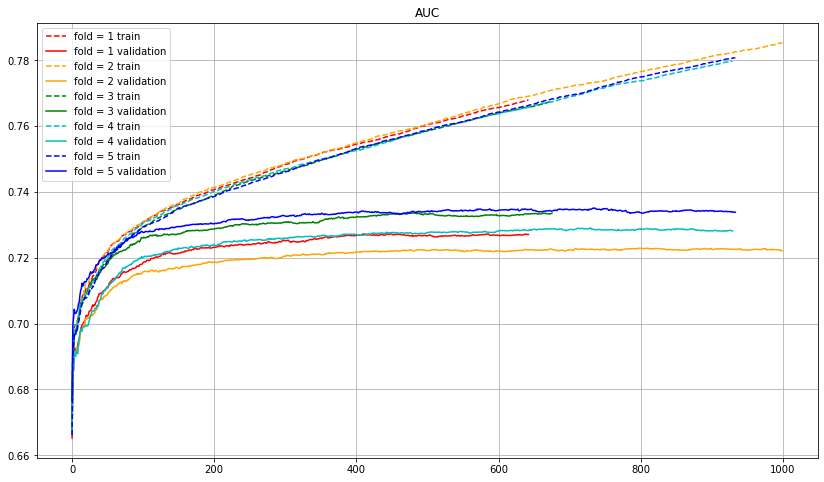

In [5]:
%%time
params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "GPU",
    
    "max_depth": 5,
    "learning_rate": 0.05,
    "n_estimators": 2000,
    "early_stopping_rounds": 200,
    
    "verbose": 200
}

cross_valid_catboost = CrossValidCatBoost(
    X=trainPrep.drop('target', axis=1),
    y=trainPrep['target'],
    cat_features=cat_features
)
estimators = cross_valid_catboost.train(
    params=params,
    n_splits=5
)

# feature importances

In [6]:
train_sample = trainPrep.sample(4000)

Xsample, ysample = train_sample.drop('target', axis=1), train_sample['target']

shap_values = 0

for model in estimators:
    explainer = shap.Explainer(model)
    shap_values += explainer.shap_values(Xsample, ysample)

shap_values /= len(estimators)
shap_values.shape

(4000, 33)

<AxesSubplot:>

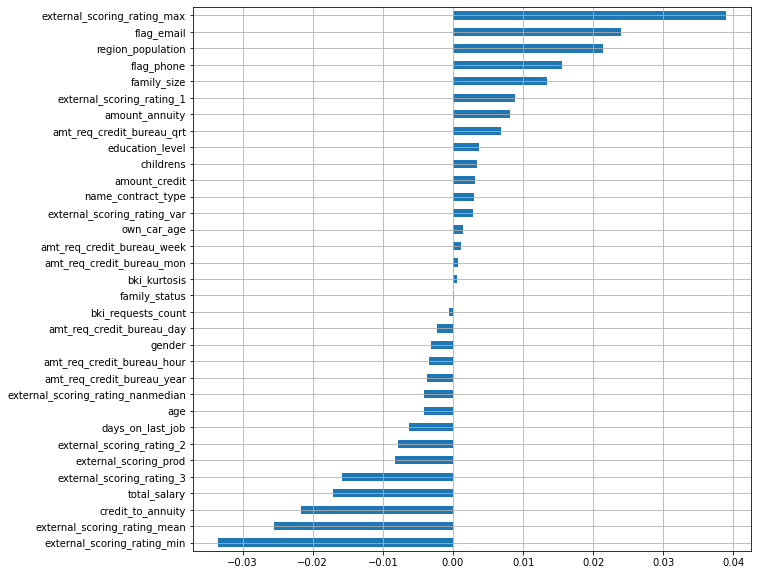

In [7]:
features_importanse = pd.Series(dict(zip(Xsample.columns, shap_values.mean(axis=0)))).sort_values()

features_importanse.plot(
    kind='barh', figsize=(10, 10), grid=True
)

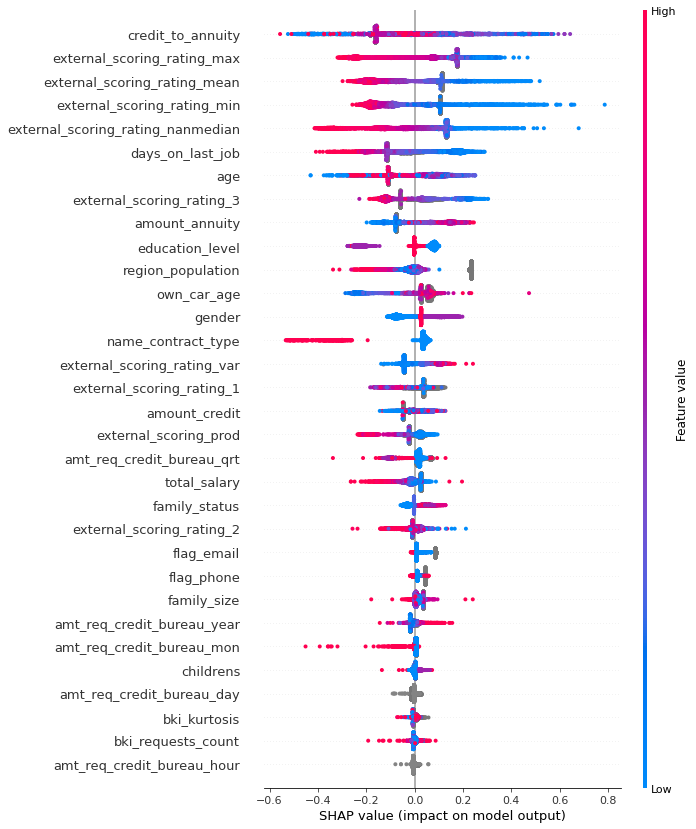

In [8]:
shap.summary_plot(shap_values, Xsample, max_display=-1)

# prediction and save test

In [9]:
%%time
testPrep = Preprocess(test, cat_features=cat_features).pipline()

test_pred = cross_valid_catboost.predict_proba(testPrep)
test_pred = pd.DataFrame({'APPLICATION_NUMBER': test['application_number'], 'TARGET': test_pred[:, 1]})

test_pred.to_csv('submition.csv', index=False)

Wall time: 3.19 s
